# 0. Imports

In [1]:
import os

# for data handling
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# for evaluation purposes
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, make_scorer

# for custom gridsearch
from itertools import product

# for handling loops
from tqdm import tqdm

# for oversampling
from imblearn.over_sampling import SMOTE, RandomOverSampler

# for saving the models
import joblib

# 1. Load Train, Val, Test Data

In [2]:
# train, val, test save_paths

data_train_save_path = os.path.join('data','train.csv')
data_val_save_path = os.path.join('data','val.csv')
data_test_save_path = os.path.join('data','test.csv')

train_val_test_save_paths = [data_train_save_path, data_val_save_path, data_test_save_path]

train_val_test_save_paths

['data/train.csv', 'data/val.csv', 'data/test.csv']

In [3]:
def load_train_val_test(train_val_test_save_paths, oversampler=None):
    # extract the dataframes
    train_data = pd.read_csv(train_val_test_save_paths[0])
    val_data = pd.read_csv(train_val_test_save_paths[1])
    test_data = pd.read_csv(train_val_test_save_paths[2])
    
    # split the data into features, labels
    y_train = train_data['label']
    X_train = train_data.drop('label', axis=1)

    # oversample the training data
    if oversampler:
        X_train, y_train = oversampler.fit_resample(X_train, y_train)


    y_val = val_data['label']
    X_val = val_data.drop('label', axis=1)

    y_test = test_data['label']
    X_test = test_data.drop('label', axis=1)

    return X_train, X_val, X_test, y_train, y_val ,y_test

In [4]:
# define an oversampler
smote = SMOTE(random_state=42)

X_train, X_val, X_test, y_train, y_val ,y_test = load_train_val_test(train_val_test_save_paths, oversampler=smote)

print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Test Data Shape:", X_test.shape)

Training Data Shape: (6530, 8444)
Validation Data Shape: (948, 8444)
Test Data Shape: (836, 8444)


# 2. Model Fit and Validation

While fitting the model to the training data, we go over various hyper-parameters and select the model which has the best `precision_score` amongst all the models.

We choose to give importance to `precision_score` because reducing **False Positives** should be our first priority, as we wouldn't want important (or any) `non-spam` text to be flagged as `spam`.

In [31]:
def train_model(X_train, X_val, y_train, y_val, classifier, param_grid):
    
    # init best model
    best_model = classifier
    
    # best precision
    best_precision = 0.0

    # make param_list by considering set products of params
    param_list = list(product(*param_grid.values()))

    for param in param_list:
        param_dict = dict(zip(param_grid.keys(), param))
        
        # init model with these params
        model = classifier.set_params(**param_dict)
        # fit the model on train data
        model.fit(X_train, y_train)

        # evaluate the model on val data
        y_val_hat = model.predict(X_val)
        # calculate precision
        current_precision = precision_score(y_val, y_val_hat, average='micro')

        # update model, score based on val precision
        if current_precision > best_precision:
            best_precision = current_precision
            best_model = model
            
            print("Current Best Precision on Val: %.3f" % best_precision)
    
    # print the best classifier
    print("Overall Best Model:", best_model)
    print("Overall Best Precision on Val: %.3f" % best_precision)

    return best_model

## 2.1 `LogisticRegression`

In [32]:
classifier = LogisticRegression()

# define the parameter search space for gridsearch

param_grid = {'penalty': ['l1', 'l2'],
              'C': [0.001, 0.01, 0.1, 1, 10],
              'solver': ['liblinear'],
              'max_iter': [100, 200, 500]}

best_logit = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )

Current Best Precision on Val: 0.877
Current Best Precision on Val: 0.935
Current Best Precision on Val: 0.978
Current Best Precision on Val: 0.983
Current Best Precision on Val: 0.984
Overall Best Model: LogisticRegression(C=10, max_iter=500, solver='liblinear')
Overall Best Precision on Val: 0.984


Best model: `LogisticRegression(C=10, max_iter=500, solver='liblinear')`

## 2.2 `RandomForestClassifier`

In [35]:
classifier = RandomForestClassifier()

# define the parameter search space for gridsearch

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

best_rfc = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )

Current Best Precision on Val: 0.955
Current Best Precision on Val: 0.961
Current Best Precision on Val: 0.967
Current Best Precision on Val: 0.970
Current Best Precision on Val: 0.972
Current Best Precision on Val: 0.974
Overall Best Model: RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=200)
Overall Best Precision on Val: 0.974


Best model: `RandomForestClassifier(max_depth=15, max_features='log2', min_samples_leaf=4, min_samples_split=10, n_estimators=200)`

## 2.3 `GradientBoostingClassifier`

In [36]:
classifier = GradientBoostingClassifier()

# define the parameter search space for gridsearch

param_grid = {
    'loss': ['log_loss', 'exponential'],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

best_gbc = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )

Current Best Precision on Val: 0.965
Current Best Precision on Val: 0.968
Current Best Precision on Val: 0.970
Current Best Precision on Val: 0.976
Current Best Precision on Val: 0.978
Current Best Precision on Val: 0.979
Current Best Precision on Val: 0.980
Current Best Precision on Val: 0.981
Current Best Precision on Val: 0.982
Overall Best Model: GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=5,
                           max_features='log2', min_samples_leaf=4,
                           min_samples_split=6, n_estimators=500)
Overall Best Precision on Val: 0.982


Best model: `GradientBoostingClassifier(learning_rate=0.01, loss='exponential', max_depth=5, max_features='log2', min_samples_leaf=4, min_samples_split=6, n_estimators=500)`

## 2.4 `AdaBoostClassifier()`

In [41]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

classifier = AdaBoostClassifier()

# define the parameter search space for gridsearch

param_grid = {'base_estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=3)],
              'n_estimators': [50, 100, 200],
              'learning_rate': [0.1, 0.5, 1.0],
              'algorithm': ['SAMME', 'SAMME.R']
             }

best_abc = train_model(
                            X_train=X_train,
                            X_val=X_val,
                            y_train=y_train,
                            y_val=y_val,
                            classifier=classifier,
                            param_grid=param_grid
                            )

Current Best Precision on Val: 0.900
Current Best Precision on Val: 0.949
Current Best Precision on Val: 0.975
Current Best Precision on Val: 0.978
Current Best Precision on Val: 0.981
Current Best Precision on Val: 0.983
Overall Best Model: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   n_estimators=200)
Overall Best Precision on Val: 0.983


Best model: `AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=200)`

# 3. Model Evaluation

We check the performance of our models on Test Data.

## 3.1 `LogisticRegression`

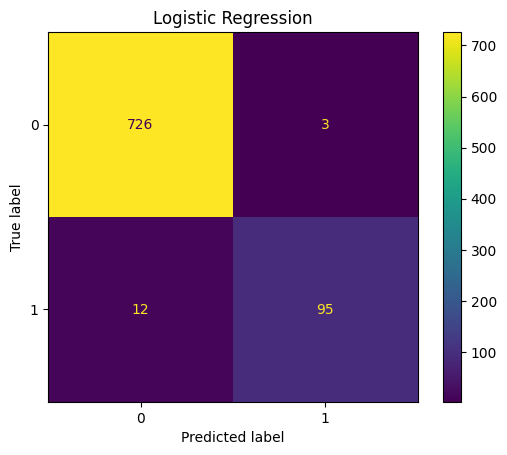

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       729
           1       0.97      0.89      0.93       107

    accuracy                           0.98       836
   macro avg       0.98      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836



In [51]:
y_test_hat = best_logit.predict(X_test)

# show confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')
plt.title("Logistic Regression")
plt.show()

# print the classification report
print(classification_report(y_test, y_test_hat))

## 2.2 `RandomForestClassifier`

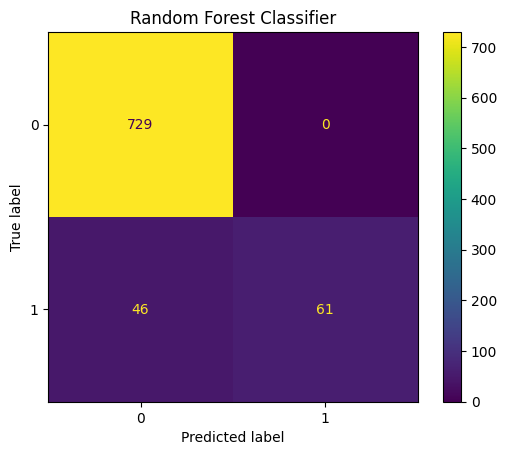

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       729
           1       1.00      0.57      0.73       107

    accuracy                           0.94       836
   macro avg       0.97      0.79      0.85       836
weighted avg       0.95      0.94      0.94       836



In [53]:
y_test_hat = best_rfc.predict(X_test)

# show confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')
plt.title("Random Forest Classifier")
plt.show()

# print the classification report
print(classification_report(y_test, y_test_hat))

## 3.3 `GradientBoostingClassifier`

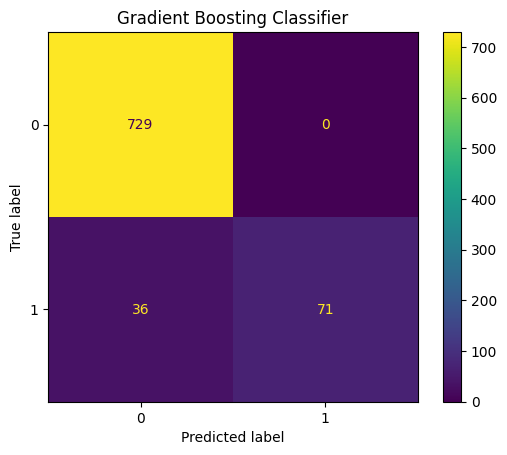

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       729
           1       1.00      0.66      0.80       107

    accuracy                           0.96       836
   macro avg       0.98      0.83      0.89       836
weighted avg       0.96      0.96      0.95       836



In [56]:
y_test_hat = best_gbc.predict(X_test)

# show confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')
plt.title("Gradient Boosting Classifier")
plt.show()

# print the classification report
print(classification_report(y_test, y_test_hat))

## 3.4 `AdaBoostClassifier()`

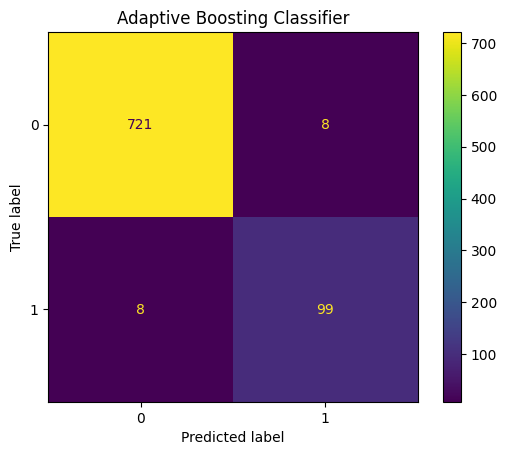

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       729
           1       0.93      0.93      0.93       107

    accuracy                           0.98       836
   macro avg       0.96      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836



In [57]:
y_test_hat = best_abc.predict(X_test)

# show confusion matrix
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, values_format='.5g')
plt.title("Adaptive Boosting Classifier")
plt.show()

# print the classification report
print(classification_report(y_test, y_test_hat))

# 4. Conclusion

Amongst all the classifier, `LogisticRegression` model seems to perform the best, with the second best `precision` score (pretty close to the best precision, with less trade-offs) and offers the highest accuracy. 

The next best classifier seems to be `GradientBoostingClassifier` for its high `precision` score, although `AdaBoostClassfier` has way better accuracy, although slightly lesser `precision` score.


Best Overall Model:
```Python
LogisticRegression(
                   C=10,
                   max_iter=500,
                   solver='liblinear'
                  )
```

In [7]:
# initialize the best classifier
best_clf = LogisticRegression(
    C=10,
    max_iter=500,
    solver='liblinear'
)

# fit the model
best_clf.fit(X_train, y_train)


LogisticRegression(C=10, max_iter=500, solver='liblinear')

In [11]:
best_clf_savepath = os.path.join('models', 'best_clf.joblib')
best_clf_savepath

'models/best_clf.joblib'

In [10]:
# save the model to the path
'''
joblib.dump(best_clf, best_clf_savepath)
'''

['models/best_clf.joblib']

In [12]:
# load the saved model
best_clf = joblib.load(best_clf_savepath)